 Pose angle dataset (with Z) saved to pose_angles_dataset_3d.csv


<Figure size 1400x600 with 0 Axes>

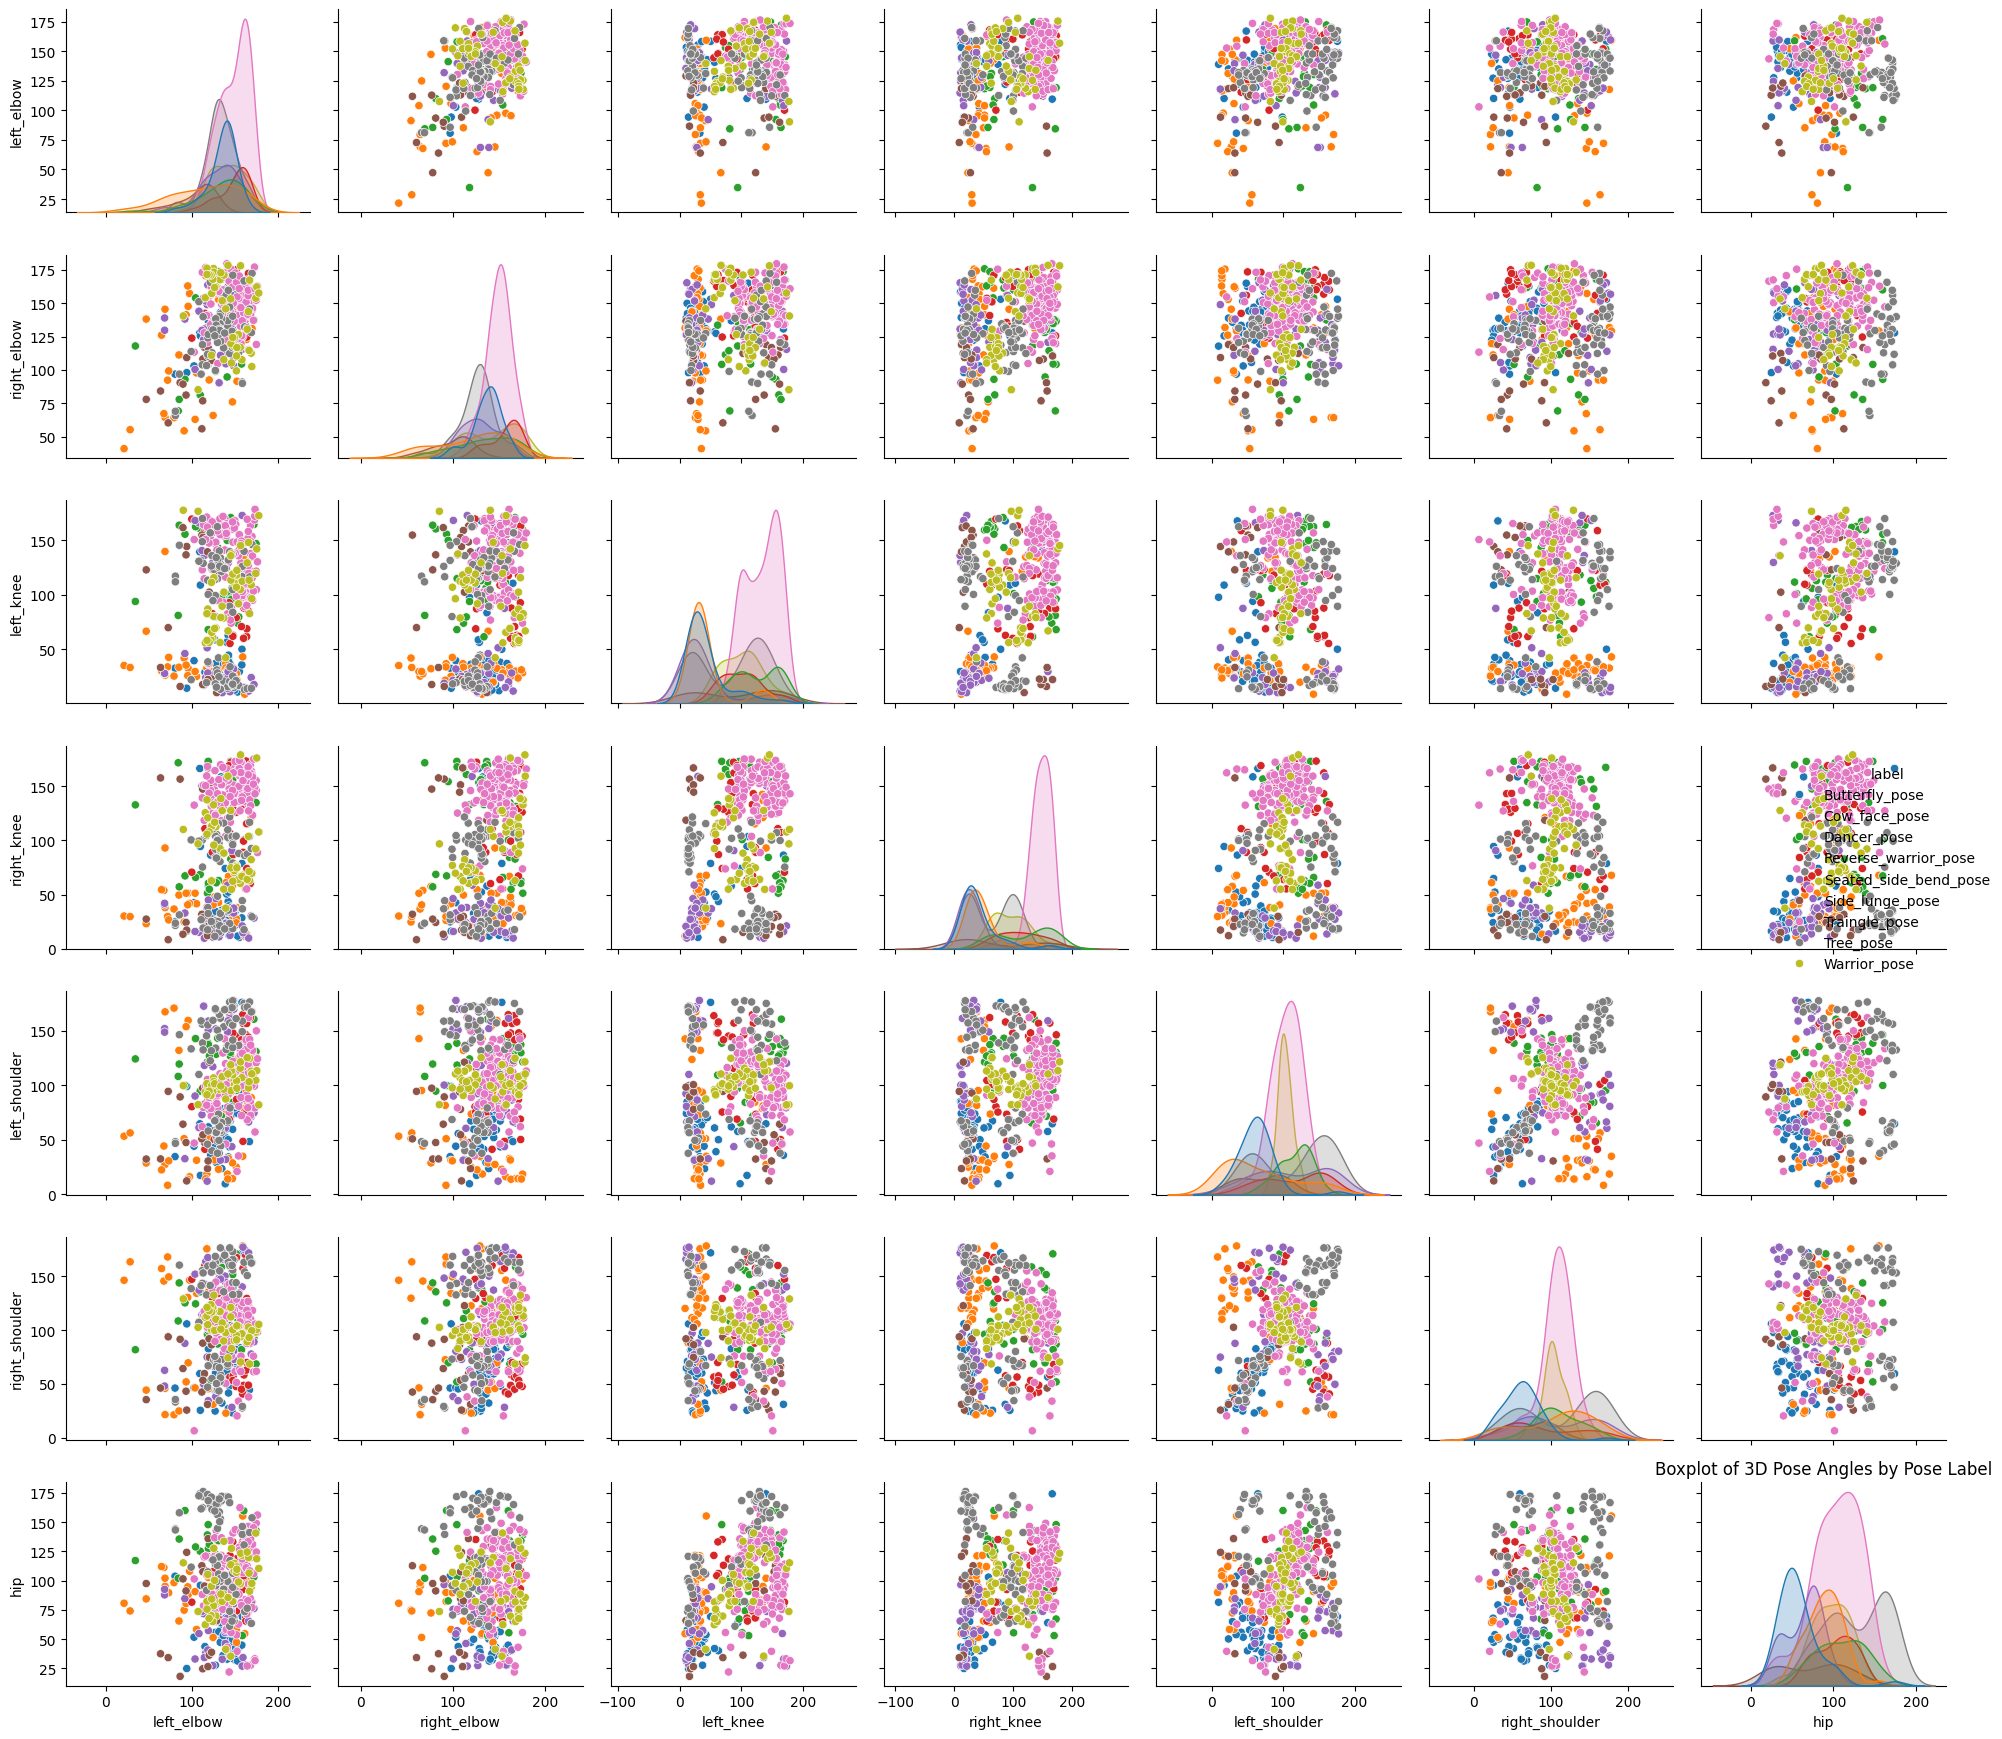

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns


# Setup Mediapipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# Define the triplets for angles
angle_points = {
    "left_elbow": (11, 13, 15),
    "right_elbow": (12, 14, 16),
    "left_knee": (23, 25, 27),
    "right_knee": (24, 26, 28),
    "left_shoulder": (13, 11, 23),
    "right_shoulder": (14, 12, 24),
    "hip": (11, 23, 25)
}

# ✅ Calculate angle in 3D (x, y, z)
def calculate_angle_3d(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    # Create vectors
    ba = a - b
    bc = c - b
    # Cosine similarity for angle
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    # Clamp to valid range to avoid floating point errors
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.degrees(np.arccos(cosine_angle))
    return angle


data = []
base_path = "yoga_dataset"  # <-- your dataset folder
for pose_name in os.listdir(base_path):
    folder = os.path.join(base_path, pose_name)
    if not os.path.isdir(folder):
        continue

    for file in os.listdir(folder):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        image_path = os.path.join(folder, file)
        image = cv2.imread(image_path)
        if image is None:
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if not results.pose_landmarks:
            continue

        lm = results.pose_landmarks.landmark
        h, w = image.shape[:2]

        angles = []
        try:
            for p1, p2, p3 in angle_points.values():
                a = [lm[p1].x * w, lm[p1].y * h, lm[p1].z * w]
                b = [lm[p2].x * w, lm[p2].y * h, lm[p2].z * w]
                c = [lm[p3].x * w, lm[p3].y * h, lm[p3].z * w]
                angle = calculate_angle_3d(a, b, c)
                angles.append(angle)

            angles.append(pose_name)  # add label at the end
            data.append(angles)

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue


columns = list(angle_points.keys()) + ['label']
df = pd.DataFrame(data, columns=columns)
df.to_csv("pose_angles_dataset_3d.csv", index=False)
print(" Pose angle dataset (with Z) saved to pose_angles_dataset_3d.csv")
plt.figure(figsize=(14, 6))
sns.pairplot(df, hue="label")
plt.title("Boxplot of 3D Pose Angles by Pose Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# Load the joint angle dataset
df = pd.read_csv("pose_angles_dataset.csv")  # Ensure this file has joint angles + 'label'

# Group by pose label and calculate mean of each angle
mean_angles = df.groupby("label").mean()

# Save the result to a CSV
mean_angles.to_csv("pose_mean_angles.csv")

print("Mean joint angles per pose saved to 'pose_mean_angles.csv'")

Mean joint angles per pose saved to 'pose_mean_angles.csv'


Epoch 1/30


c:\Users\shres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1577 - loss: 25.8106 - val_accuracy: 0.2472 - val_loss: 12.8970
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3604 - loss: 9.0983 - val_accuracy: 0.2809 - val_loss: 6.3444
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3065 - loss: 5.3171 - val_accuracy: 0.5056 - val_loss: 4.6594
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5465 - loss: 3.4742 - val_accuracy: 0.5281 - val_loss: 3.1026
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5986 - loss: 2.2683 - val_accuracy: 0.5618 - val_loss: 2.8122
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6729 - loss: 1.8086 - val_accuracy: 0.5955 - val_loss: 2.3360
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6797 - loss: 1.4967 - val_accuracy: 0.6180 - val_loss: 2.2934
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7455 - loss: 1.1126 - val_accuracy: 0.6292 - val_loss: 1.9

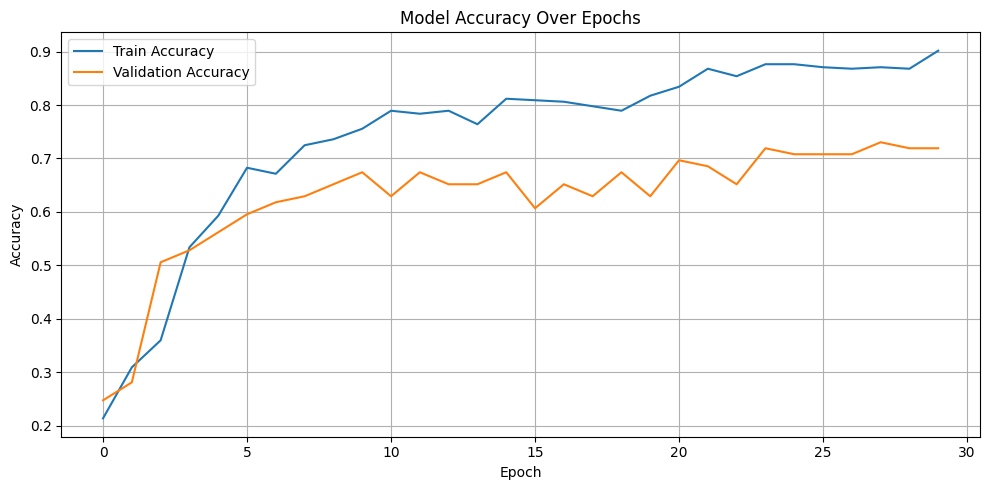

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load data
df = pd.read_csv("pose_angles_dataset_3d.csv")
X = df.drop("label", axis=1).values
y = LabelEncoder().fit_transform(df["label"])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

# Save model
model.save("angle_pose_model.h5")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
def inFrame(lst):
	if lst[28].visibility > 0.6 and lst[27].visibility > 0.6 and lst[15].visibility>0.6 and lst[16].visibility>0.6:
		return True 
	return False

model = tf.keras.models.load_model("angle_pose_model.h5")
labels = df["label"].unique()

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    return 360 - angle if angle > 180 else angle

angle_points = {
    "left_elbow": (11, 13, 15),
    "right_elbow": (12, 14, 16),
    "left_knee": (23, 25, 27),
    "right_knee": (24, 26, 28),
    "left_shoulder": (13, 11, 23),
    "right_shoulder": (14, 12, 24),
    "hip": (11, 23, 25)
}


cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.6,
                  min_tracking_confidence=0.6) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR to RGB for mediapipe
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(img_rgb)

        # Convert back to BGR for OpenCV visualization
        frame = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

        # Process landmarks
        if results.pose_landmarks and inFrame(results.pose_landmarks.landmark):
            lm = results.pose_landmarks.landmark
            h, w = frame.shape[:2]

            # Collect angles
            angles = []
            all_angles_captured = True

            for p1, p2, p3 in angle_points.values():
                try:
                    a = [lm[p1].x * w, lm[p1].y * h]
                    b = [lm[p2].x * w, lm[p2].y * h]
                    c = [lm[p3].x * w, lm[p3].y * h]
                    angle = calculate_angle(a, b, c)
                    angles.append(angle)
                except:
                    all_angles_captured = False
                    break

            # Only predict if all angles were successfully calculated
            if all_angles_captured and len(angles) == len(angle_points):
                input_data = np.array(angles).reshape(1, -1)
                pred = model.predict(input_data)[0]
                index = np.argmax(pred)
                confidence = pred[index]

                if confidence > 0.9:
                    label = labels[index]
                    color = (0, 255, 0)  # green
                else:
                    label = "Unknown Pose"
                    color = (0, 0, 255)  # red

                # Display pose label
                cv2.putText(frame, f'{label} ({confidence*100:.1f}%)', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

            # Draw landmarks
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS
            )

        # Show frame
        cv2.imshow('Real-time Yoga Pose Detection', frame)

        # Break on 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


NameError: name 'df' is not defined

In [ ]:
import tensorflow as tf

# Load the trained .h5 model
model = tf.keras.models.load_model("angle_pose_model.h5")

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open("angle_pose_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Conversion complete. Saved as angle_pose_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\shres\AppData\Local\Temp\tmp34zg3u87\assets


INFO:tensorflow:Assets written to: C:\Users\shres\AppData\Local\Temp\tmp34zg3u87\assets


Saved artifact at 'C:\Users\shres\AppData\Local\Temp\tmp34zg3u87'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  2791170792464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2791170792848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2791170791312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2791170794576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2790639751376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2791170792656: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Conversion complete. Saved as angle_pose_model.tflite


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import json

# Load the data
df = pd.read_csv("pose_angles_dataset_3d.csv")

# Create and fit the label encoder
le = LabelEncoder()
le.fit(df["label"])

# Create label map with native Python integers
label_map = {int(k): v for k, v in zip(le.transform(le.classes_), le.classes_)}

# Save to file
with open("label_map.json", "w") as f:
    json.dump(label_map, f, indent=4) 